# Reinforcement Learning miniproject 

Nikolai Zaki & Oliver Atanaszov

Project repository: https://github.com/imLew/MHBF-project
    

In [41]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from sarsa_demo import Agent, simulation, plot_cumulative_rewards, plot_learning_curve, plot_vectorfield, test_place

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Introduction

## Introduction

In this report we present the results of our implementation of the SARSA algorithm with eligibility traces and function approximation. We implement and evaluate this algorithm for the task of sequentially reaching two different locations in a simple maze.

SARSA is an on-policy algorithm that belongs to the category of reinforcement learning. The essence of the algorithm is to update the policy based on the reward expected under the current policy, in this it differs from the otherwise similar Q-learning algorithm which updates the policy based on the an ideal learning strategy. The main difference in outcome is that Q-learning can find a one time optimal solutioin while SARSA will find the a policy that maximizes the expected reward. Two additions are made to the original SARSA algortihm. First is the use of eligibility traces, which is a method of keeping track of past actions in order distribute credit over the series of actions that lead to a reward more appropriately. Second is the use of so-called function approximation by which a continuous state space can be used.

The goal is to simulate an agent (e.g. a mouse) that is moving inside a T-shaped maze and has to first move to a "pick-up" area before it proceeds to the target area where it receives a reward. Important here is that the agent does not receive a rewards for reaching the pick-up area. The only positive reward is thus collected upon completing the entire task. In addition to this there is a negative reward for running into a wall. Together these are reasonable describtion of tasks that real rodents might learn.

Specifically, the agent in the model received an input that was it position and generated as an output a movement step that consisted of a distance and a direction. The distance was drawn from a normal distribution, $\mathcal{N}(3,1.5^2)$, with units of cm. The direction was chosen by an $\epsilon-$greedy policy. As long as the agent had not completed the task the movement step was added to the original position in order to generate a new input. After each step the agents policy was updated to better reflect the value of the step it just performed based on any reward it received and the reward it expected to get from the next step. This update rule can be summarized as
\begin{equation}
\label{basic_update}
Q(a_t,s_t) \to \eta\big(r_t + \gamma Q(a_{t+1},s_{t+1}) - Q(a_t,s_t)\big) + Q(a_t,s_t),
\end{equation}
where $\eta$ represents the learning rate, $\gamma$ the discount factor applied to future expected rewards, $r_t$ the current reward and $Q(a_t,s_t)$ represents the expected reward of performing action $a_t$ in state $s_t$.

## Model Construction

In order to generate the output (action) of the agent from the input a two layered neural network was used (i.e. only input and output layer). The policy was thus encoded in the synaptic weights of the network and the policy update could be implemented by changing these weights.

### Input Layer

In rodents cells have been found that fire when the animal is in a specific location within its environment. The method of function approximation we used can be understood as analogous to these cells.

In order to encode the position of the agent, which is represented by an ordered tuple $\bar{x}\in \mathbb{R}^2$ a number positions in the maze were chosen at which the different nodes in the input layer would have high activity. In this way the conitinuous state space can be represented by a finite number of cells. Each of the cells received the current position as input and its acivity, $r_j$, was then commputed as
\begin{equation}
\label{place_cell_acivity}
r_j = \frac{1}{\sqrt{2\pi}\sigma}\exp(-\frac{||\bar{x}-\bar{x}_j||}{2\sigma^2}).
\end{equation}
The figure below shows the positions of the place cells, their color represents their activation if the input is located at the red 'x'.

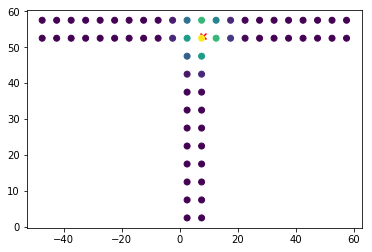

In [15]:
position = [8,53]
test_place(position)

Diverging from the biological realism another identical layer of input cells was created. The two layer were used to differentiate between the time before the agent had visited the pickup area and the time after. In the notation they are marked by the subscript $\beta$ which can take values 0 or 1 so $r_j$ above becomes $r_{j \alpha} = \delta_{\alpha \beta} r_j$ where $\beta$ is 0 if the agent has not visited the pick-up area and 1 if it has.

### Output Layer and Policy

In the output layer each cells corresponded to a different direction and its activation directly represented the Q values of the the policy so that 
\begin{equation}
\label{output_layer}
Q(a,s) = \sum_{j \alpha} w_{a \alpha j}r_{j \alpha}.
\end{equation}
This computation allows the agent to have two different Q-values for the same position by making its memory of having visited the pick-up area part of its current state.

### Weight Updates

The update rule for the Q-values as given in eq. \ref{basic_update} only distributes any reward found to the action-state pairs that came right before receiving the reward. This completely dismisses any relevance previous actions might have had towards received the reward. In order to alleviate this weakness of the algorithm eligibility traces can be used which keep track of the place cells that have recently active. This is done by creating an array of the same dimesionality as the weight array and at each step adding the current activation to the elements corresponding to the actions taken at that step. In order to decrease the relevance of actions in the past these traces decay exponentially.

Let $e(a,s)$ be the trace value corresponding to action $a$ in state $s$. Then the update rule for the trace and $Q$-values is
\begin{equation}
\label{Q_update_rule}
e(a,s) \to \gamma \lambda e_{\alpha}(a,s) \\
e_{j}(a_t,s) \to e_{j}(a_t,s) + r_j(s) \textrm{for all }j \\
Q(a, s) \to \eta\big(r_t + \gamma Q(a_{t+1},s_{t+1})-Q(a_t,s_t)\big)e(a,s)+Q(a,s).
\end{equation}

A key difference to the naive update rule is that now all Q-values are updated. If we translate the update rule to the weights we have to introduce a subscript to differentiate the traces associated with different states of $\beta$, i.e. pick-up, it is then written as
\begin{equation}
\label{update_rule}
e_{\alpha}(a,s) \to \gamma \lambda e_{\alpha}(a,s) \\
e_{j\alpha}}(a_t,s) \to e_{j\alpha}}(a_t,s) + r_j(s) \textrm{for all }j \\
w_{a\alpha j} \to \eta\big(r_t + \gamma Q(a_{t+1},s_{t+1})-Q(a_t,s_t)\big)e_{\alpha}(a,s)+w_{a\alpha j}.
\end{equation}

## Mice Getting Their Cheese

With the model as described above the agents learn to solve the maze. Below is a series of trajectories of an agent, from completely naive to having trained 20 times.

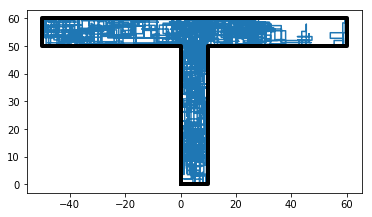

In [57]:
mouse = Agent()
mouse.trial(plot=True);

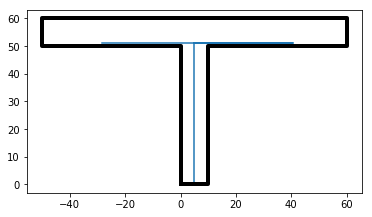

In [58]:
for i in range(18): mouse.trial()
mouse.trial(plot=True);

At first the agent explores the environment with movements that are practically all random. Indeed the agent uses an $\epsilon-$greedy policy with $\epsilon$ beginning at 0.9 and decreasing by a factor 0.8 each trial. 90% of the actions in the first trial are therefore entirely random, however the remaining 10% are based on a policy that is derived from randomly initialized weights, the agent might possibly learn a bit but this is practically random.

After 20 trials the agent can be seen to perform much better, following a very efficient trajectory. At this point the exploration parameter has decreased to around 1% so the agent can fully exploit what it learned.

# Model analysis

We now go into a more detail of the model and its performance, by recording the latency (ie. the escape time). To this end we begin with the learning curves, i.e. the number of steps taken per trial to complete consecutive trials of the same agent. As can shortly be seen from the learning curves of individual agents the algorithm is not stable. That is to say that sometimes after several trials in which the agent completed the task efficiently it might take a very long time to complete the task. For this reason 20 agents are simulated here over 50 trials and in the learning curves we plot the average number of steps taken per trial.

Another thing to note with regards to stability of the algorithm is that the learning rate must be taken to be small, $\eta<0.1$, in order for the agent to be able to learn. The problem that occurs is that the Q-values diverge to the point where they become too large for the computer too handle. Even for $\eta \approx 0.1$ this can happen and we have here chosen $\eta=0.01$. However this is only a bandaid fix since the underlying problem is a lack of normalization in the algorithm. Such normalization would require knowledge (and thus computation) of all Q-values at all times instead of only the Q-values of the actions that can be undertaken in the current state.

For these reasons we included the $max\_iter$ parameter in the simulation function, if the number of steps in a single trial exceeds the number thus specified the trial is aborted. 

First we show some relevant plots with the following set of parameters: #actions = 4, $\epsilon$ = 0.99, $\lambda$ = 0.95, $\gamma$ = 0.95, $\eta$ = 0.01.
Later we will vary some of these parameters to showcase their effects.

In [59]:
cumulativeReward, latencies, aborts = simulation(Agent, nTrials = 50, nAgents = 20, nActions = 4, maxIter=1e5,
                      eps0 = .99,  decayRate = .95, gamma = .95, eta = 0.01, verbose = 0);

## Training

Below we show to figures of the learning rate, the first over all agents and the second only over the agents that did not have any aborted trials.
The transparent curves in the background show the learning of individual agents. Filtering out those that exceeded the maximum number of steps makes the average curve much smoother but it can be seen that there is a large variability during the first $\approx 20$ trials among all agents.

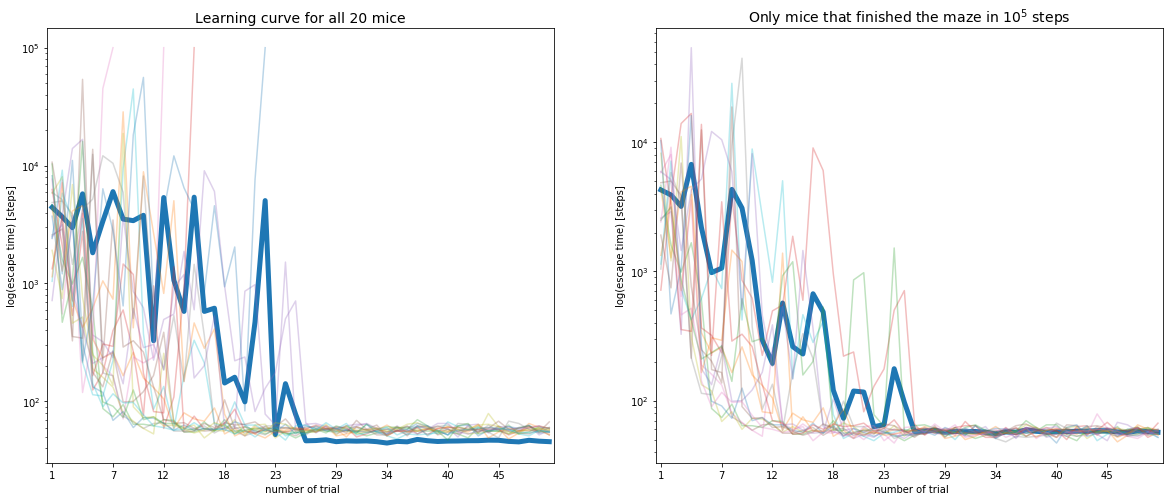

In [60]:
plot_learning_curve(latencies, aborts)

Fig. 1: Learning curves of 10 mice (colors) and the averaged curve (blue) over trial number. The y-axis shows in a logarithmic scale how many steps are needed for the mouse to escape the maze. Left: learning curves for all mice included, right: only the ones that escaped in max. $10^5$ steps.

## Rewards

Another interesting type of curve is the cumulative reward that the agents aquire over the consecutive trials. While the learning curve above demonstrated how well the algorithm performed in regards to solving the maze these curves reveal more about the secondary, though complementary, goal of not running into walls.

There is a large variance in these curves from agent to agent. The general pattern seems to be that those agents that learned quicker to solve the maze, as can be seen from the length of the curves, also learned to better avoid the walls as can be seen from the slope of the curves. In the first few trials the slope of all the lines is the same as at this point the agents have not learned to avoid the walls. With time though the curves should get flatter and eventually the slope should become positive when the agents run into less than 20 walls per trial.

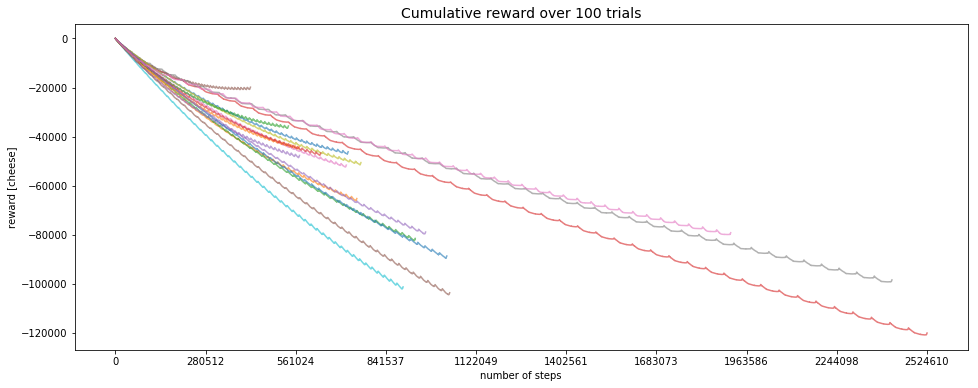

In [51]:
plot_cumulative_rewards(cumulativeReward, aborts)

Fig. 2: Cumulative rewards over steps for 10 mice and 100 trials (ie. the value of total gained reward up until the step number on the x-axis). 

## Visualization of the Policy

The learning can be visualized in a more qualitative way by plotting a vector field that at each location shows the direction corresponding to the direction (i.e. action) with the highest Q-value at that point. Since the agent also as two internal states, the value of the pick-up parameter, for each point in time we need two vector fields to fully describe the policy. Below we have plotted such vector fields after various numbers of trials. The local coherence in the early plots is likely due to the large size of the place fields (they have a radius of 5cm). The plots show that as the agent learns the vectors line up as would be expected.

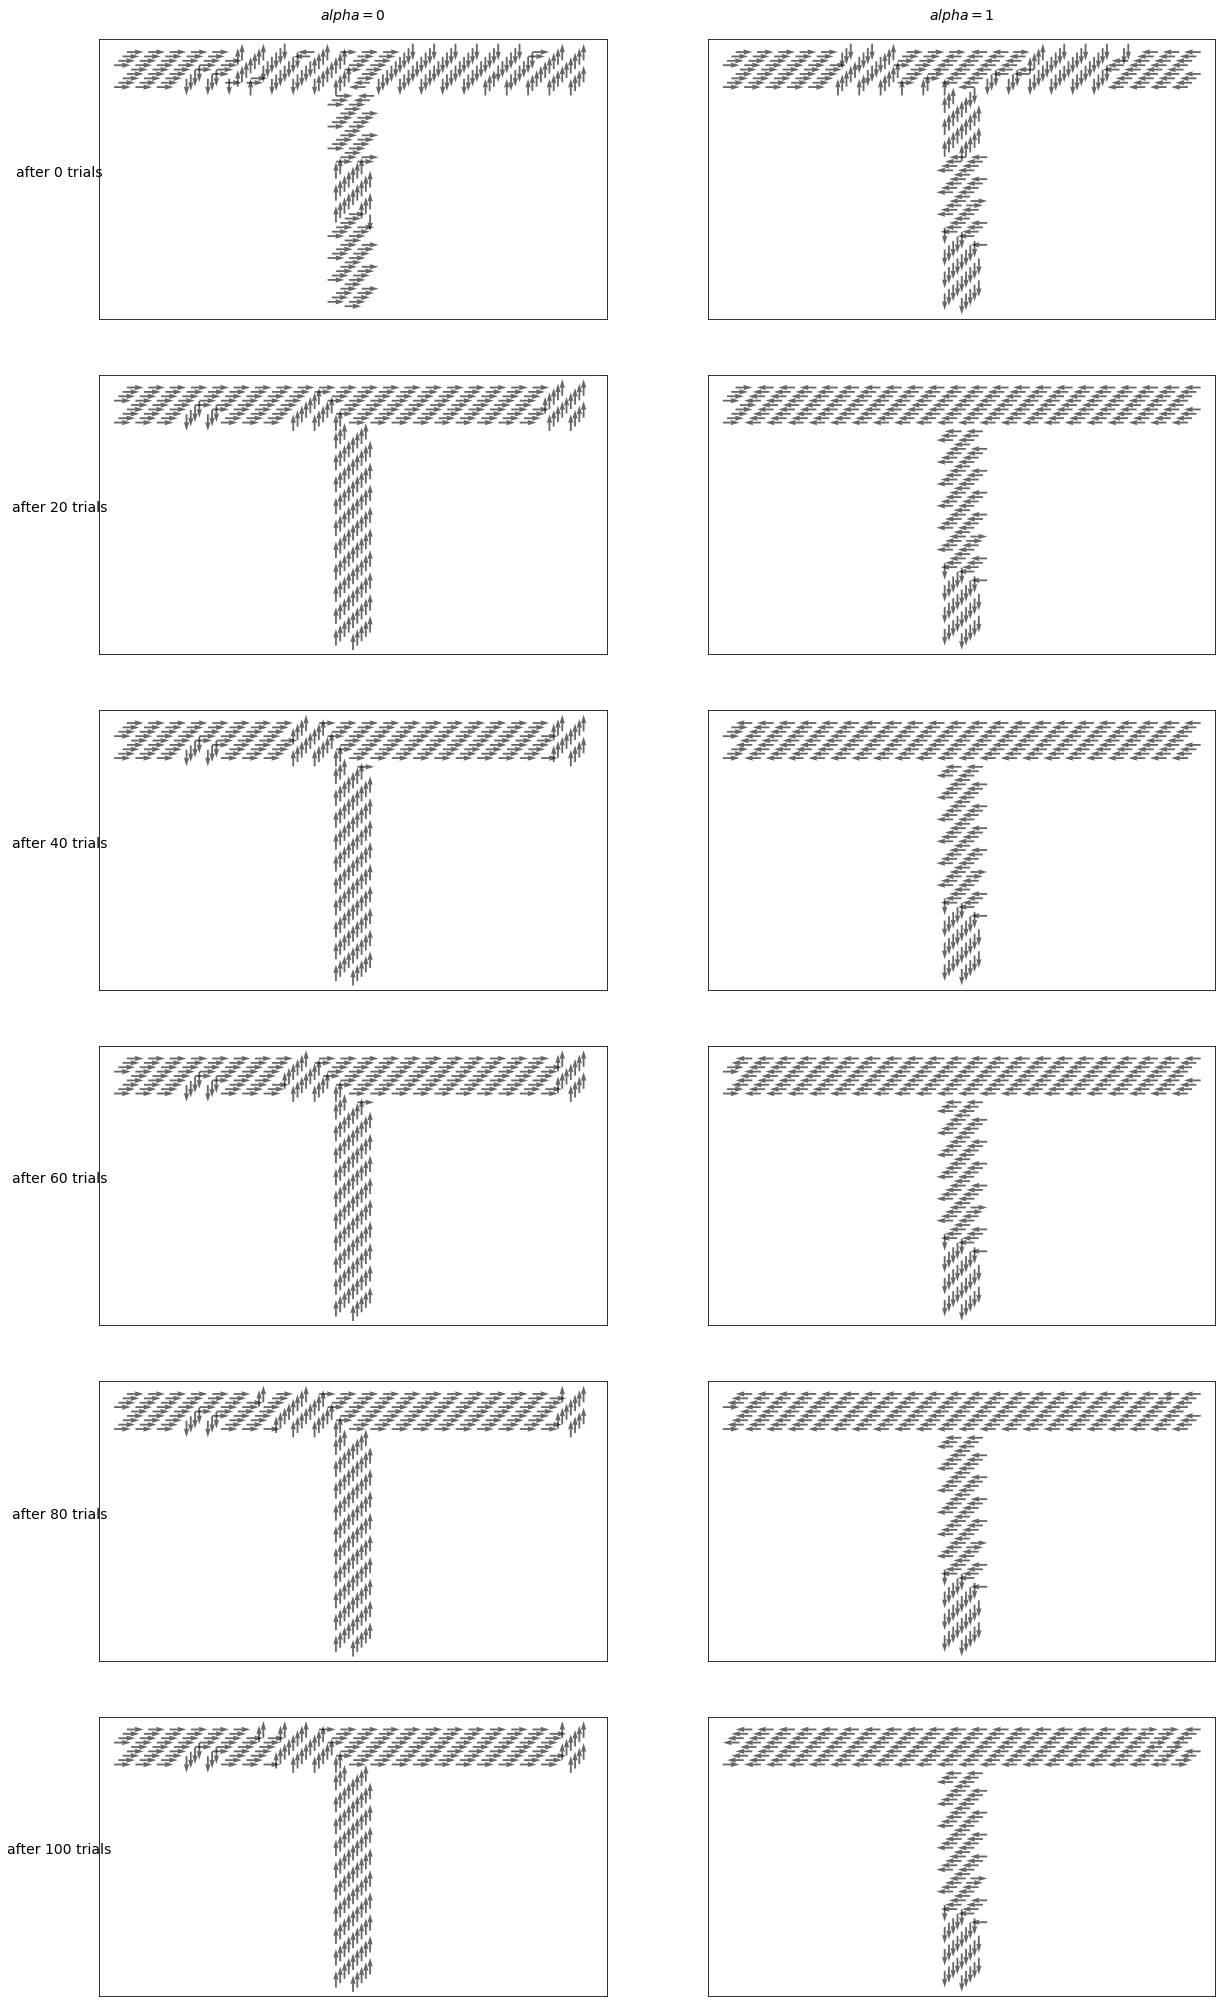

In [52]:
plot_vectorfield(Agent)

Fig. 3: Vector-fields of the policy determining the animals behaviour if it was acting in a maximum greedy manner (only exploitation). Left column: before finding the pickup area, right column: after finding the pickup area. From top to bottom the vector fields after increasing number of training trials are shown.

## Parameters

### Decay rate of eligibility traces ($\lambda$)

The idea behind eligibility traces is to make the Q-updates less local and diffuse them backwards through some part of the past experiences. This means that we maintain a (decaying) trace of where the agent has been previously (the rate of decay is controlled by the parameter $\lambda$), and performing Q-value updates along some recent history of the SARSA-chains. If the agent discovers some reward in one state, the algorithm updates not only the Q-value of the previous step, but a number of steps leading to the reward too (the trace).
Therefore $\lambda = 0$ means no eligibility traces, only the step leading to the reward is updated, and essentially theres no learning of sequences of optimal steps.


In [56]:
lambdas = [0,0.5, 0.95]

In [58]:
mean_latencies = np.zeros(len(lambdas))
for i, lambda_ in enumerate(lambdas):
    print(i, 'lambda = ', lambda_)
    cumulativeReward, latencies, aborts = simulation(Agent, nTrials = 20, nAgents = 10, nActions = 4, maxIter=1e5,
                      eps0 = .99,  decayRate = lambda_, gamma = .95, eta = 0.001, verbose = 1);
    mask = np.asarray([np.any(aborts[i])==False for i in range(10)]) #filter out mice that got stuck
    mean_latencies[i] = latencies[aborts].mean(axis = 0)


0 lambda =  0
mouse #1: 16.40 s
mouse #2: 9.52 s
mouse #3: 7.70 s
mouse #4: 8.83 s
mouse #5: 7.79 s
mouse #6: 6.85 s
mouse #7: 3.62 s
mouse #8: 8.84 s
mouse #9: 15.20 s
mouse #10: 8.04 s


IndexError: arrays used as indices must be of integer (or boolean) type

In [55]:
latencies[aborts]

IndexError: arrays used as indices must be of integer (or boolean) type

In [ ]:
plt.plot(lambdas, mean_latencies)

In [ ]:
lambda = 0 - doesnt learn
lambda = 1 - 

### Exploration/exploitation parameter ($\epsilon$)

The parameter $\epsilon$ controls the greedyness of the agent's behaviour. By probability $1-\epsilon$ it moves according to the maximum output (Q-values, 'exploitation') whereas it moves to a random direction by a probability of $\epsilon$ ('exploration'). This means that by decreasing it over trials the animal behaves more and more based on the current maximal Q-values, that are meant to show the right direction to go in order to accomplish the task. By keeping the weights unchanged between consecutive trials (weight update was introduced in 2.2.3.) we ensure that in latter trials they reflect the 'optimal' policy and therefore decreasing $\epsilon$ over trials results in lower latency times.

## More Directions

The agent needs at least three directions in oder to be able to solve the maze. While there is no hard maximum, increasing the number of direction beyond four seems to have little benefit but it does has some clear drawbacks. Firstly, it is more difficult to optimize the algorithm for directions that are not parallel to the axes, we were not able to do this and therefore a direct comparison between the time taken to solve the maze using different numbers of directions is not possible. Secondly however the algorithm will also learn slower with more directions due to the update rule. To see why we can compare the case of four directions with that of 40. Imagine the mouse has just been initialized and is in the bottom of the maze, in the case of four directions all but one action will lead to a negative reward in one or two steps (if the same action is taken twice). In the case of fourty actions however there are many more actions that will lead the agent to a wall and also many that will lead it upward through the maze and many in and between these two categories will be very similar. However since only the actions actually performed will have their Q-values updated. The agent is effectively unable to categorize its actions. This means that the mouse will have to run into the same right-side wall several times, approaching it at many different angle before it learns that going towards the right is a bad idea before it reaches the top of the maze.

As mentioned we cannot compare the learning curves directly to the ones we plotted above. We can however compare multiple non-otimized cases such as 8, 12 and 16 actions. We keep all other parameters the same as above.

### 8 directions

In [10]:
cumulativeReward_8, latencies_8, aborts_8 = simulation(Agent, nTrials = 50, nAgents = 10, nActions = 8, maxIter=1e5,
                      eps0 = .99,  decayRate = .95, gamma = .95, eta = 0.005, verbose = 1);

mouse #1: 9.60 s
mouse #2: 13.26 s
mouse #3: 2.37 s
mouse #4: 8.93 s
mouse #5: 2.66 s
mouse #6: 8.33 s
mouse #7: 11.47 s
mouse #8: 2.44 s
mouse #9: 8.10 s
mouse #10: 2.56 s


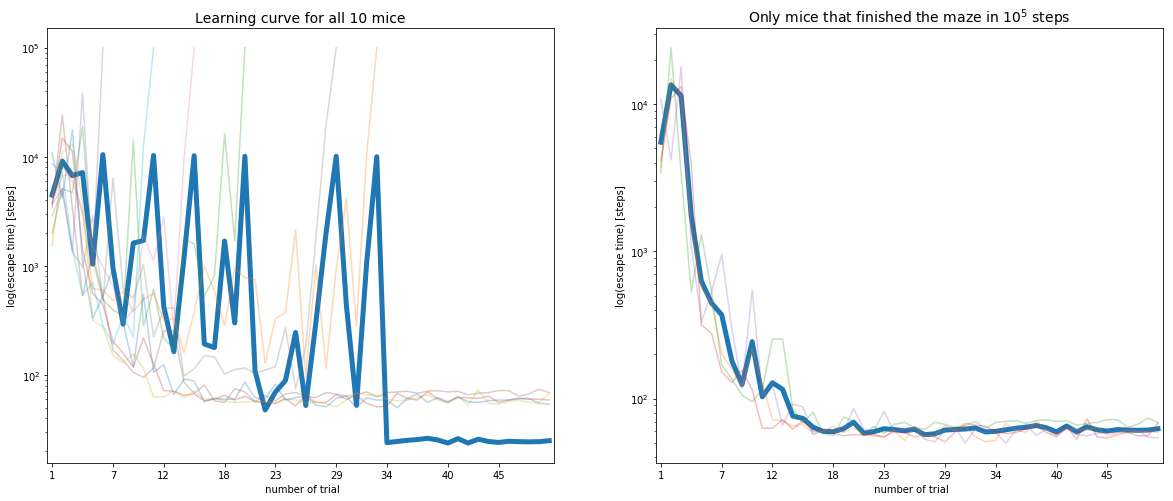

In [11]:
plot_learning_curve(latencies_8, aborts_8)

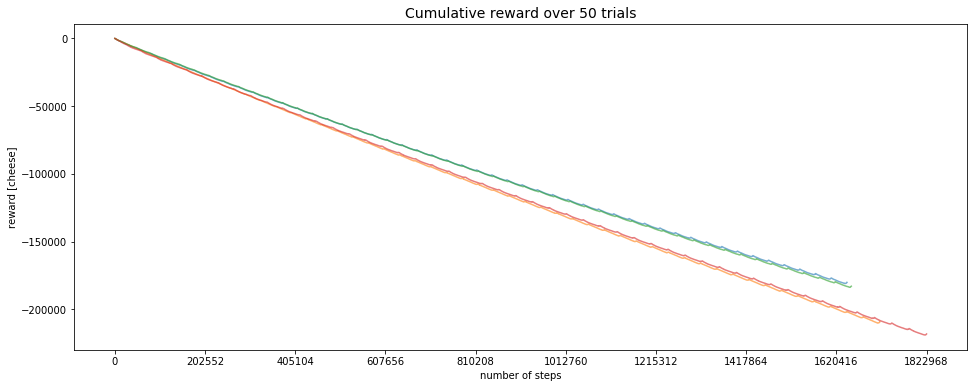

In [12]:
plot_cumulative_rewards(cumulativeReward_8, aborts_8)

### 16 directions

In [35]:
cumulativeReward_16, latencies_16, aborts_16 = simulation(Agent, nTrials = 50, nAgents = 10, nActions = 16, maxIter=1e5,
                      eps0 = .99,  decayRate = .95, gamma = .95, eta = 0.001, verbose = 1);

mouse #1: 13.64 s
mouse #2: 13.41 s
mouse #3: 8.19 s
mouse #4: 14.59 s
mouse #5: 15.40 s
mouse #6: 8.73 s
mouse #7: 11.45 s
mouse #8: 7.76 s
mouse #9: 13.21 s
mouse #10: 13.22 s


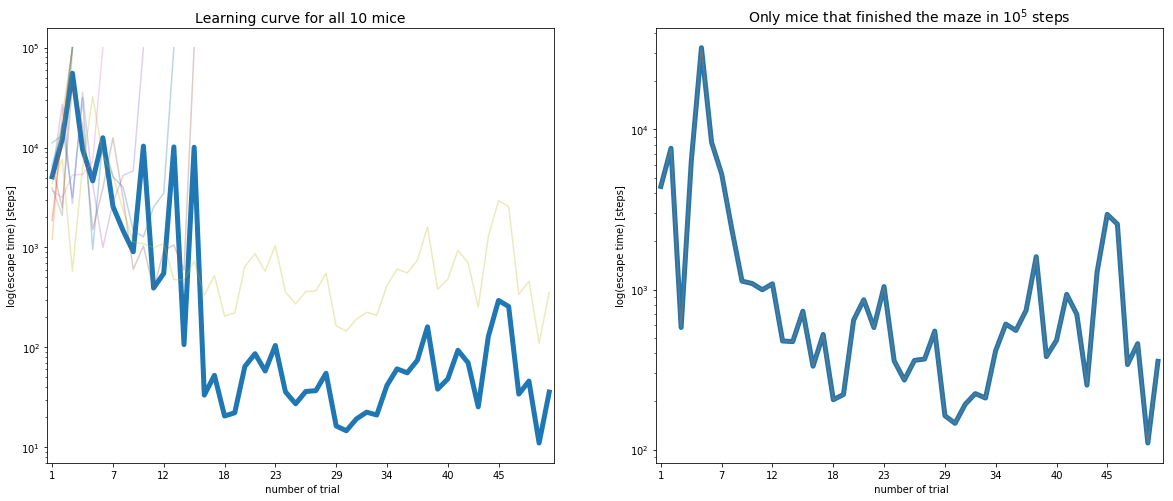

In [37]:
plot_learning_curve(latencies_16, aborts_16)